In [18]:
# Basic Template
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ncxt_psftomo

from ncxt_psftomo.numba_bl import A_bl, sA_bl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# import os
# os.environ['NUMBA_OPT'] = '1'

In [23]:
def find_instr(func, keyword, sig=0, limit=5):
    count = 0
    for l in func.inspect_asm(func.signatures[sig]).split('\n'):
        if keyword in l:
            count += 1
            print(l)
            if count >= limit:
                break
    if count == 0:
        print('No instructions found')

### Test BL projectors

In [24]:
from ncxt_psftomo.numba_bl import A_bl, sA_bl
dtype = 'float32'
L = 128
na =90

angles = np.linspace(0,np.pi,na,endpoint = False).astype(dtype)
phantom = np.random.random((L,L,L)).astype(dtype)
projections = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]),dtype = dtype)

A_bl(phantom, projections, angles)
sA_bl(phantom, projections, angles)

for func in [A_bl, sA_bl]:
    print()
    sig = 0
    find_instr(func, keyword='subp', sig=sig)
    find_instr(func, keyword='addp', sig=sig)
    find_instr(func, keyword='mulp', sig=sig)
    find_instr(func, keyword='madd', sig=sig)

%timeit A_bl(phantom,projections,angles)
%timeit sA_bl(phantom,projections,angles)


No instructions found
No instructions found
No instructions found
	vfmadd213sd	%xmm7, %xmm10, %xmm0
	vfmadd213sd	%xmm7, %xmm10, %xmm11
	vfmadd213sd	336(%rsp), %xmm2, %xmm12
	vfmadd213sd	%xmm12, %xmm0, %xmm3
	vfmadd132sd	(%rax), %xmm2, %xmm13

No instructions found
No instructions found
No instructions found
	vfmadd213sd	%xmm0, %xmm1, %xmm8
	vfmadd213sd	%xmm0, %xmm1, %xmm7
	vfmadd213sd	%xmm0, %xmm1, %xmm6
	vfmadd213sd	888(%rsp), %xmm1, %xmm8
	vfmadd213sd	%xmm8, %xmm9, %xmm6
157 ms ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
35.6 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Test PSF proj

In [38]:
from ncxt_psftomo.numba_common import A_psf
from ncxt_psftomo.numba_psf import sA_psf, sA_psf2

dtype = 'float32'
resolution = 2
dof = L
psf_r = 3

angles = np.linspace(0,np.pi,na,endpoint = False).astype(dtype)
phantom = np.random.random((L,L,L)).astype(dtype)
psf = ncxt_psftomo.psf_utils.psf_volume(resolution,dof,psf_r,512).astype(dtype)
projections = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]),dtype = dtype)

print('phantom',phantom.shape)
print('projections',projections.shape)
print('psf',psf.shape)

sA_psf(phantom, projections,psf, angles)
sA_psf2(phantom, projections,psf, angles)


for func in [sA_psf,sA_psf2]:
    print()
    sig = 0
    find_instr(func, keyword='subp', sig=sig)
    find_instr(func, keyword='addp', sig=sig)
    find_instr(func, keyword='mulp', sig=sig)
    find_instr(func, keyword='madd', sig=sig)

%timeit sA_psf(phantom,projections,psf,angles)
%timeit sA_psf2(phantom,projections,psf,angles)


phantom (128, 128, 128)
projections (90, 128, 128)
psf (512, 7, 7)

No instructions found
No instructions found
No instructions found
	vfmadd213sd	%xmm0, %xmm1, %xmm8
	vfmadd213sd	%xmm0, %xmm1, %xmm9
	vfmadd213sd	%xmm0, %xmm1, %xmm6
	vfmadd213sd	%xmm0, %xmm1, %xmm7
	vfmadd213sd	2232(%rsp), %xmm11, %xmm6

No instructions found
	vaddps	%ymm3, %ymm2, %ymm2
	vaddps	%ymm0, %ymm1, %ymm0
	vaddps	%ymm2, %ymm0, %ymm0
	vaddps	%xmm0, %xmm1, %xmm0
	vaddps	%xmm0, %xmm1, %xmm0
No instructions found
	vfmadd213sd	%xmm0, %xmm1, %xmm8
	vfmadd213sd	%xmm0, %xmm1, %xmm9
	vfmadd213sd	%xmm0, %xmm1, %xmm6
	vfmadd213sd	%xmm0, %xmm1, %xmm7
	vfmadd213sd	2184(%rsp), %xmm11, %xmm6
3.1 s ± 307 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.1 s ± 36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%timeit sA_psf(phantom,projections,psf,angles)
%timeit sA_psf2(phantom,projections,psf,angles)


3.09 s ± 92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.14 s ± 86.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
check summation of kernel before add!

In [12]:
from numba import njit,jit, prange
import numba
from math import sin, cos
from ncxt_psftomo.numba_common import piece_wise_integrated

@njit(fastmath=True)
def A_bl_fm(vol,Ax,angles, reset= True):
    nx,ny,nh = vol.shape
    pa,px,ph = Ax.shape
    xcent = nx/2-0.5
    ycent = ny/2-0.5
    pcent = px/2-0.5
    
    if reset:
        Ax*=0
        
    for ai in prange(pa):
        cosphi = cos(angles[ai])
        sinphi = sin(angles[ai])
        b = (0.5 * abs(cosphi - sinphi))
        a = (0.5 * abs(cosphi + sinphi))
        if b<a:
            a,b=b,a
        lmax = (1 / (a+b))

        for xi in range(nx):
            for yi in range(ny):
                xp = (xi - xcent) * cosphi + (yi - ycent) * sinphi + pcent
                iqx = round(xp)
                xv = (iqx - xp)
                    
                val1 = piece_wise_integrated(xv - 0.5, a,b,lmax)
                val2 = piece_wise_integrated(xv + 0.5, a,b,lmax)
                wx0 = val1
                wx1 = val2 - val1
                wx2 = 1.0 - val2

    

                if (iqx - 1 >= 0 and iqx - 1 < px):
                    for zi in range(nh): 
                        Ax[ai,iqx - 1,zi]+=vol[xi,yi,zi] * wx0

                        # if ai==0 and zi==0 and xi==10 and yi==10:
                        #     print(type(Ax[ai,iqx - 1,zi])) 
                        #     print(type(vol[xi,yi,zi])) 
                        #     print(type(wx0)) 

                if (iqx  >= 0 and iqx  < px):
                    for zi in range(nh): 
                        Ax[ai,iqx,zi]+=vol[xi,yi,zi] * wx1
                if (iqx + 1 >= 0 and iqx + 1 < px):
                    for zi in range(nh): 
                        Ax[ai,iqx+1,zi]+=vol[xi,yi,zi] * wx2
        
                        
A_bl_fm(phantom,projections,angles)


for func in [A_bl_fm]:
    print()
    sig = 0
    find_instr(func, keyword='subp', sig=sig)
    find_instr(func, keyword='addp', sig=sig)
    find_instr(func, keyword='mulp', sig=sig)
    find_instr(func, keyword='madd', sig=sig)


No instructions found
No instructions found
No instructions found
	vfmadd213sd	%xmm15, %xmm11, %xmm0
	vfmadd213sd	%xmm15, %xmm11, %xmm6
	vfmadd213sd	376(%rsp), %xmm2, %xmm12
	vfmadd213sd	%xmm12, %xmm0, %xmm3
	vfmadd132sd	(%rcx), %xmm2, %xmm13


In [190]:
%timeit A_bl_fm(phantom,projections,angles)
%timeit A_bl_nfm(phantom,projections,angles)

1.29 s ± 193 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.6 s ± 384 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
L = 256
na =90

for dtype in ['float32', 'float64']:
    print()
    angles = np.linspace(0,np.pi,na,endpoint = False).astype(dtype)
    phantom = np.random.random((L,L,L)).astype(dtype)
    projections = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]),dtype = dtype)

    # ensure compilation
    A_bl(phantom, projections, angles)
    sA_bl(phantom, projections, angles)

    print(f'generic({dtype})')
    %timeit A_bl(phantom, projections, angles)
    print(f'float({dtype})')
    %timeit sA_bl(phantom, projections, angles)
    
A_bl.signatures


generic(float32)
272 ms ± 15.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
float(float32)
256 ms ± 9.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

generic(float64)
569 ms ± 20.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
float(float64)
559 ms ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


[(Array(float32, 3, 'C', False, aligned=True),
  Array(float32, 3, 'C', False, aligned=True),
  Array(float32, 1, 'C', False, aligned=True),
  omitted(default=True)),
 (Array(float64, 3, 'C', False, aligned=True),
  Array(float64, 3, 'C', False, aligned=True),
  Array(float64, 1, 'C', False, aligned=True),
  omitted(default=True))]

In [29]:
print('---\A_bl:')
sig = 0
find_instr(A_bl, keyword='subp', sig=sig)
find_instr(A_bl, keyword='addp', sig=sig)
find_instr(A_bl, keyword='mulp', sig=sig)

sig = 1
find_instr(A_bl, keyword='subp', sig=sig)
find_instr(A_bl, keyword='addp', sig=sig)
find_instr(A_bl, keyword='mulp', sig=sig)

---\A_bl:
No instructions found
No instructions found
No instructions found
No instructions found
No instructions found
No instructions found


In [16]:
# sA_bl.inspect_types()
from ncxt_psftomo.numba_common import A_psf_order

L = 16
na = 3
angles = np.linspace(0,np.pi,na,endpoint = False).astype('float32')
phantom = np.zeros((L,L,L)).astype('float32')
R = 2
psf = np.zeros((2*L,2*R+1,2*R+1),dtype = 'float32')
projections = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]), dtype = 'float32')
A_psf_order(phantom, projections, psf, angles)

find_instr(A_psf_order, keyword='subp', sig=0)
find_instr(A_psf_order, keyword='addp', sig=0)
find_instr(A_psf_order, keyword='mulp', sig=0)

No instructions found
	vaddpd	-224(%rdx,%rsi,8), %ymm0, %ymm0
	vaddpd	-192(%rdx,%rsi,8), %ymm1, %ymm1
	vaddpd	-160(%rdx,%rsi,8), %ymm2, %ymm2
	vaddpd	-128(%rdx,%rsi,8), %ymm3, %ymm3
	vaddpd	-96(%rdx,%rsi,8), %ymm0, %ymm0
No instructions found


In [41]:
axpy.signatures
find_instr(axpy, keyword='addp', sig=0)
find_instr(axpy, keyword='addp', sig=1)

	vaddpd	(%r10,%rax,8), %ymm1, %ymm1
	vaddpd	32(%r10,%rax,8), %ymm3, %ymm3
	vaddpd	64(%r10,%rax,8), %ymm4, %ymm4
	vaddpd	96(%r10,%rax,8), %ymm5, %ymm5
	vaddpd	128(%r10,%rax,8), %ymm1, %ymm1
	vaddps	(%r10,%rax,4), %ymm1, %ymm1
	vaddps	32(%r10,%rax,4), %ymm3, %ymm3
	vaddps	64(%r10,%rax,4), %ymm4, %ymm4
	vaddps	96(%r10,%rax,4), %ymm5, %ymm5
	vaddps	128(%r10,%rax,4), %ymm1, %ymm1


In [19]:
sig = 0
find_instr(A_psf_order, keyword='subp', sig=sig)
find_instr(A_psf_order, keyword='addp', sig=sig)
find_instr(A_psf_order, keyword='mulp', sig=sig)

sig = 1
find_instr(A_psf_order, keyword='subp', sig=sig)
find_instr(A_psf_order, keyword='addp', sig=sig)
find_instr(A_psf_order, keyword='mulp', sig=sig)

sig = 2
find_instr(A_psf_order, keyword='subp', sig=sig)
find_instr(A_psf_order, keyword='addp', sig=sig)
find_instr(A_psf_order, keyword='mulp', sig=sig)

No instructions found
	vaddpd	-224(%rdx,%rsi,8), %ymm0, %ymm0
	vaddpd	-192(%rdx,%rsi,8), %ymm1, %ymm1
	vaddpd	-160(%rdx,%rsi,8), %ymm2, %ymm2
	vaddpd	-128(%rdx,%rsi,8), %ymm3, %ymm3
	vaddpd	-96(%rdx,%rsi,8), %ymm0, %ymm0
No instructions found
No instructions found
	vaddpd	-224(%rdx,%rsi,8), %ymm0, %ymm0
	vaddpd	-192(%rdx,%rsi,8), %ymm1, %ymm1
	vaddpd	-160(%rdx,%rsi,8), %ymm2, %ymm2
	vaddpd	-128(%rdx,%rsi,8), %ymm3, %ymm3
	vaddpd	-96(%rdx,%rsi,8), %ymm0, %ymm0
No instructions found
No instructions found
	vaddpd	-224(%rdx,%rsi,8), %ymm0, %ymm0
	vaddpd	-192(%rdx,%rsi,8), %ymm1, %ymm1
	vaddpd	-160(%rdx,%rsi,8), %ymm2, %ymm2
	vaddpd	-128(%rdx,%rsi,8), %ymm3, %ymm3
	vaddpd	-96(%rdx,%rsi,8), %ymm0, %ymm0
No instructions found


(32, 5, 5)
4096.0
19968.0


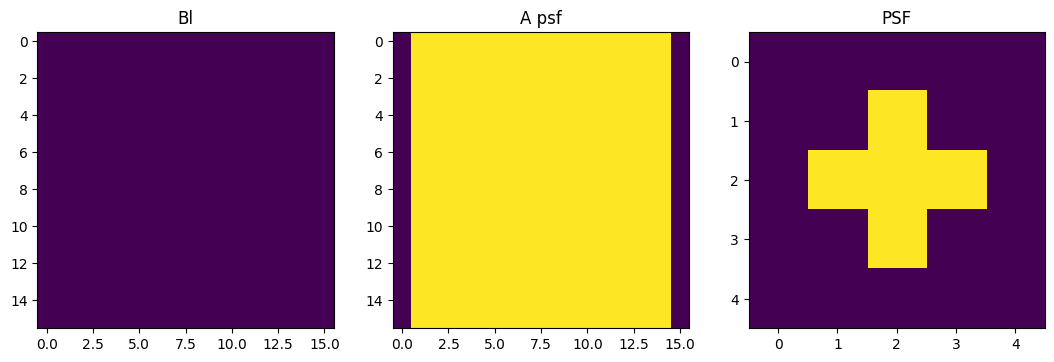

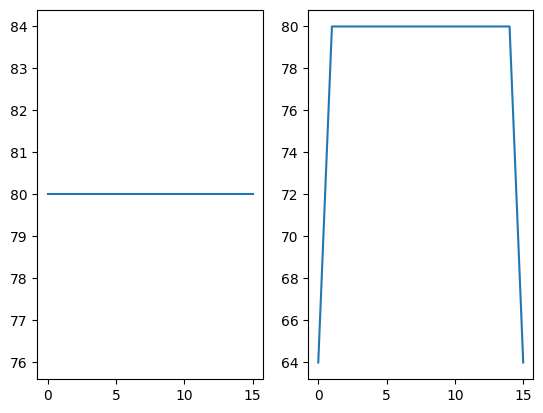

In [39]:
from ncxt_psftomo.numba import A_bl,sA_psf_order

L = 16
na = 3
angles = np.linspace(0,np.pi,na,endpoint = False)
phantom = np.zeros((L,L,L)).astype('float32')
# phantom[8,8,:]=1
phantom = phantom*0+1
R = 2

psf = np.zeros((2*L,2*R+1,2*R+1))
print(psf.shape)
psf[:,1:4,2]=1
psf[:,2,1:4]=1
psf[:,R,R]=1




# psf[:,3,3]=1


projections0 = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]), dtype = 'float32')
projections1 = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]), dtype = 'float32')

A_bl(phantom, projections0, angles)
sA_psf_order(phantom, projections1, psf, angles)

ai = 0
f, (ax1,ax2,ax3)= plt.subplots(ncols = 3,figsize = (13,5))
ax1.imshow(projections0[ai].transpose())
ax2.imshow(projections1[ai].transpose())
ax3.imshow(psf[L//2,:,:].transpose())
ax1.set_title('Bl')
ax2.set_title('A psf')
ax3.set_title('PSF')

print(np.sum(projections0[0]))
print(np.sum(projections1[0]))

plt.show()


f, (ax1,ax2)= plt.subplots(ncols = 2)
ax1.plot(projections1[0,L//2,:])
ax2.plot(projections1[0,:,L//2])
plt.show()


In [40]:
# typical NCXT
L = 512
na = 10
phantom = np.random.random((L,L,L)).astype('float32')
angles = np.linspace(0,np.pi,10,endpoint = False)

resolution = 3
dof = 300
psf = ncxt_psftomo.psf_utils.psf_volume(resolution,dof,2,512).astype('float32')
                                                                     


In [49]:
%%time

from ncxt_psftomo.numba import A_psf,A_psf_order2,sA_psf_order
projections = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]), dtype = 'float32')
ATx = (phantom*0).astype('float32')

CPU times: total: 359 ms
Wall time: 362 ms


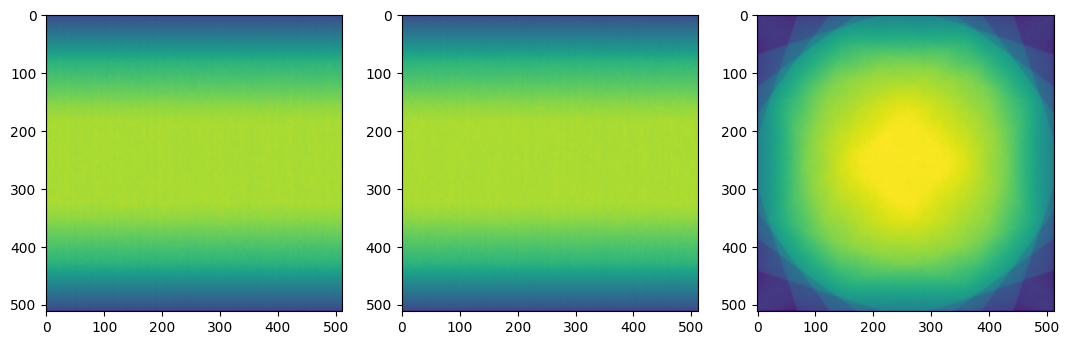

In [50]:
%%time

from ncxt_psftomo.numba import sAT_psf_order
sA_psf_order(phantom, projections, psf, angles)
sAT_psf_order(projections, ATx, psf, angles)

ncxt_psftomo.plotters.volshow(ATx)
plt.show()

In [51]:
print(np.sum(projections))
print(np.sum(ATx))

633257540.0
320660240000.0


In [2]:
ncxt_psftomo.test_omp()

4

(128, 128, 128)


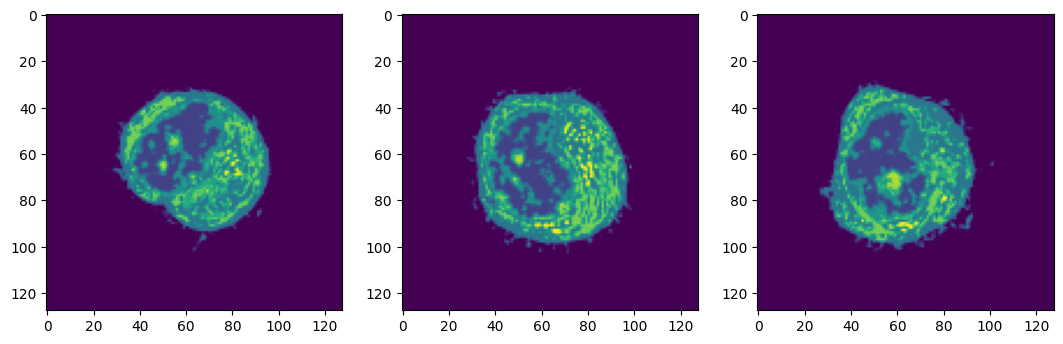

In [3]:
phantom = ncxt_psftomo.read_write_mrc.read_mrc('data/phantom.mrc')
ncxt_psftomo.plotters.volshow(phantom)
print(phantom.shape)
phantom.dtype
plt.show()


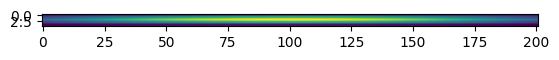

(201, 5, 5)


In [4]:
resolution = 3
dof = 100
psf = ncxt_psftomo.psf_utils.psf_volume(resolution,dof,2,201)
plt.imshow(ncxt_psftomo.psf_utils.psf_slice(resolution,dof,2,201))
plt.show()
print(psf.shape)

In [65]:
phantom32 = phantom.astype('float32')
phantom64 = phantom.astype('float64')

projections32 = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]),dtype='float32')
projections64 = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]),dtype='float64')

psf32 = psf.astype('float32')
psf64 = psf.astype('float64')


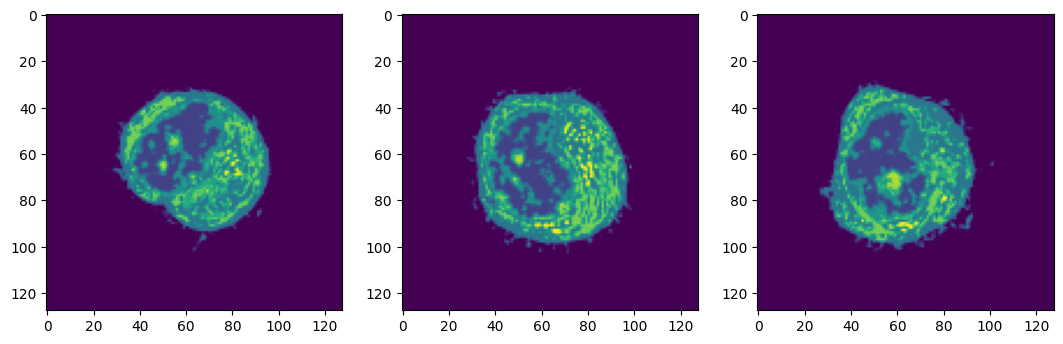

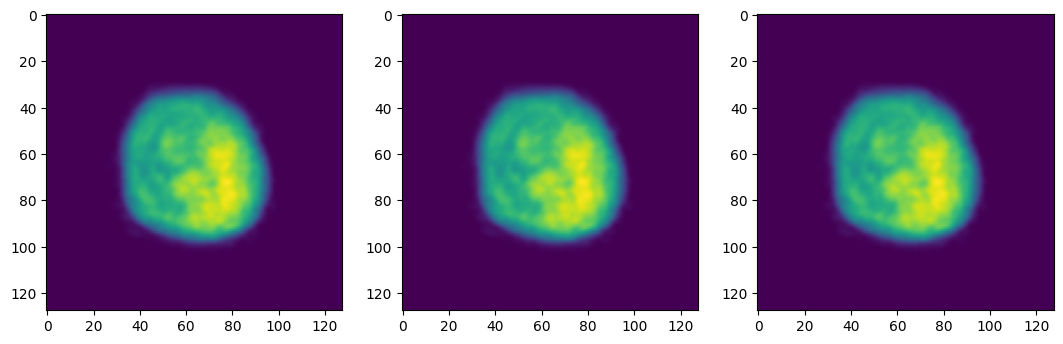

In [68]:

projections0 = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]))
projections1 = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]))
projections2 = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]))
A_psf(phantom, projections0, psf, angles)
A_psf_order2(phantom, projections1, psf, angles)
sA_psf_order(phantom, projections2, psf, angles)

f, (ax1,ax2,ax3)= plt.subplots(ncols = 3,figsize = (13,5))
ax1.imshow(projections0[0])
ax2.imshow(projections1[0])
ax3.imshow(projections2[0])

plt.show()

In [71]:
%%time

%timeit A_psf(phantom64, projections64, psf64, angles)
%timeit A_psf_order2(phantom64, projections64, psf64, angles)
%timeit sA_psf_order(phantom64, projections64, psf64, angles)

%timeit A_psf(phantom32, projections32, psf32, angles)
%timeit A_psf_order2(phantom32, projections32, psf32, angles)
%timeit sA_psf_order(phantom32, projections32, psf32, angles)

1.91 s ± 6.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
284 ms ± 7.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
280 ms ± 6.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.28 s ± 20.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
245 ms ± 9.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
233 ms ± 7.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
CPU times: total: 55.9 s
Wall time: 41.8 s


In [70]:
sA_psf_order.signatures

[(Array(float32, 3, 'C', False, aligned=True),
  Array(float64, 3, 'C', False, aligned=True),
  Array(float64, 3, 'C', False, aligned=True),
  Array(float64, 1, 'C', False, aligned=True),
  omitted(default=True)),
 (Array(float64, 3, 'C', False, aligned=True),
  Array(float64, 3, 'C', False, aligned=True),
  Array(float64, 3, 'C', False, aligned=True),
  Array(float64, 1, 'C', False, aligned=True),
  omitted(default=True)),
 (Array(float32, 3, 'C', False, aligned=True),
  Array(float32, 3, 'C', False, aligned=True),
  Array(float32, 3, 'C', False, aligned=True),
  Array(float64, 1, 'C', False, aligned=True),
  omitted(default=True))]

In [7]:
projections0 = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]), dtype = 'float32')
projections1 = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]), dtype = 'float32')
projections2 = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]), dtype = 'float32')

print(phantom.dtype)
print(projections0.dtype)
print(projections1.dtype)
print(psf.dtype)

print(phantom.shape)
print(projections0.shape)
print(projections1.shape)
print(psf.shape)

float32
float32
float32
float32
(256, 256, 256)
(10, 256, 256)
(10, 256, 256)
(512, 5, 5)


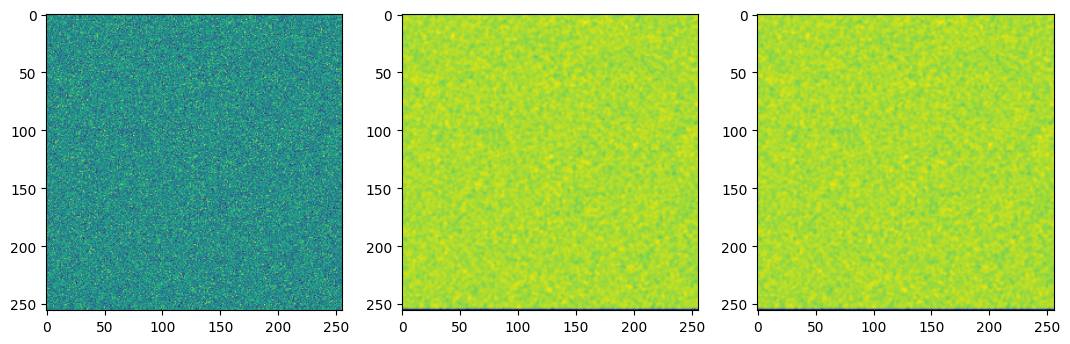

In [20]:
A_bl(phantom, projections0, angles)
A_psf_order2(phantom, projections1, psf, angles)
sA_psf_order(phantom, projections2, psf, angles)


f, (ax1,ax2,ax3)= plt.subplots(ncols = 3,figsize = (13,5))
ax1.imshow(projections0[0])
ax2.imshow(projections1[0])
ax3.imshow(projections2[0])

plt.show()

In [23]:
%timeit A_bl(phantom, projections0,  angles)
%timeit A_psf_order2(phantom, projections1, psf, angles)
%timeit sA_psf_order(phantom, projections2, psf, angles)

42.6 ms ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.66 s ± 1.55 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.59 s ± 467 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


IndexError: index 10 is out of bounds for axis 0 with size 3

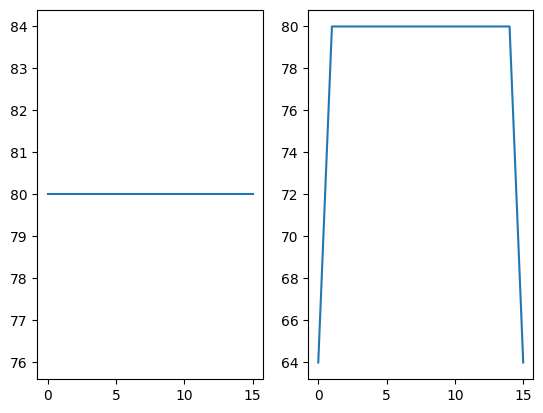

In [62]:
projections0[0,L//2,:]

array([16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16.], dtype=float32)